In [23]:
import pandas as pd
import numpy as np
data_rfe=pd.read_csv('norm_tongren.csv')
data_rfe=np.array(data_rfe)
fea=data_rfe[:,:49]
target=data_rfe[:,49]
x_test=fea[:170,:]
y_test=target[:170]
x_train=fea[170:,:]
y_train=target[170:]

# SVM-RFE_RELIEF

In [24]:
from skfeature.function.similarity_based import reliefF
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from numpy import mean 
from sklearn.model_selection import cross_val_score
class rfe_relief_SVM:
    def __init__(self,x_train,y_train,c,gamma):
        self.X_train=x_train
        self.Y_train=y_train
        self.C=c
        self.Gamma=gamma
    def featu_score(self,alpha,folds):
        #kf=KFold(n_splits=folds,shuffle=False)
        estimator=SVC(C=self.C, kernel='rbf',gamma=self.Gamma)
        rank_=[]
        featu_num=self.X_train.shape[1]
        candi_fea=[j for j in range(featu_num)]
        i=featu_num
        aver_lis=[j for j in range(featu_num)]
        F_lis=[j for j in range(featu_num)]
        aver=mean(cross_val_score(estimator,x_train,y_train,scoring="accuracy",cv=folds,n_jobs=-1))
        aver_lis[i-1]=aver
        F1=mean(cross_val_score(estimator,x_train,y_train,scoring="f1",cv=folds,n_jobs=-1))
        F_lis[i-1]=F1
        while True:
            relief_score=(reliefF.reliefF(self.X_train[:,candi_fea],self.Y_train)).reshape(1,i)
            #print(relief_score)
            estimator.fit(self.X_train[:,candi_fea],self.Y_train)
            suppor_index=estimator.support_
            support_num=len(suppor_index)
            support_vector=estimator.support_vectors_
            dual_coef=estimator.dual_coef_[0]
            rfe_score=[i for i in range(len(candi_fea))]
            z=np.exp(-self.Gamma*np.sum(support_vector*support_vector,axis=1))
            matrix_z=np.outer(z, z)
            y_matrix=np.outer(self.Y_train[suppor_index],self.Y_train[suppor_index])
            H_matrix=np.exp(2*self.Gamma*support_vector@support_vector.T)*matrix_z*y_matrix
            orig_loss=np.dot(np.dot(dual_coef*self.Y_train[suppor_index],H_matrix),dual_coef*self.Y_train[suppor_index])
            k=0
            for fea in candi_fea:
                copy_support_vector=self.X_train[suppor_index,:]
                candi_fea_copy=candi_fea.copy()
                #print(len(candi_fea_copy))
                candi_fea_copy.remove(fea)
                removed_support_vector=copy_support_vector[:,candi_fea_copy]
                z1=np.exp(-self.Gamma*np.sum(removed_support_vector*removed_support_vector,axis=1))
                matrix_z1=np.outer(z1, z1)
                H_matrix1=np.exp(2*self.Gamma*removed_support_vector@removed_support_vector.T)*matrix_z1*y_matrix
                after_loss=np.dot(np.dot(dual_coef*self.Y_train[suppor_index],H_matrix1),dual_coef*self.Y_train[suppor_index])
                scor_fea=np.abs(orig_loss-after_loss)/2
                rfe_score[k]=scor_fea
                k=k+1     
            total_score=alpha*relief_score+(1-alpha)*np.array(rfe_score)
            #print(total_score)
            index_=np.argmin(total_score)
            remove_fea=candi_fea[index_]
            candi_fea.remove(remove_fea)
            i-=1
            aver=mean(cross_val_score(estimator,self.X_train[:,candi_fea],self.Y_train,scoring="accuracy",cv=folds,n_jobs=-1))
            F1=mean(cross_val_score(estimator,self.X_train[:,candi_fea],self.Y_train,scoring="f1",cv=folds,n_jobs=-1))
            aver_lis[i-1]=aver
            F_lis[i-1]=F1
            if i==1:
                break
        return aver_lis,F_lis
    def sele_feature(self,alpha,optim_featur_num):
        estimator=SVC(C=self.C, kernel='rbf',gamma=self.Gamma)
        rank_=[]
        featu_num=self.X_train.shape[1]
        candi_fea=[i for i in range(featu_num)]
        i=featu_num
        while True:
            if len(candi_fea)==optim_featur_num:
                return candi_fea
            relief_score=(reliefF.reliefF(self.X_train[:,candi_fea],self.Y_train)).reshape(1,i)
            estimator.fit(self.X_train[:,candi_fea],self.Y_train)
            suppor_index=estimator.support_
            support_num=len(suppor_index)
            support_vector=estimator.support_vectors_
            dual_coef=estimator.dual_coef_[0]
            rfe_score=[i for i in range(len(candi_fea))]
            z=np.exp(-self.Gamma*np.sum(support_vector*support_vector,axis=1))
            matrix_z=np.outer(z, z)
            y_matrix=np.outer(self.Y_train[suppor_index],self.Y_train[suppor_index])
            H_matrix=np.exp(2*self.Gamma*support_vector@support_vector.T)*matrix_z*y_matrix
            orig_loss=np.dot(np.dot(dual_coef*self.Y_train[suppor_index],H_matrix),dual_coef*self.Y_train[suppor_index])
            k=0
            for fea in candi_fea:
                copy_support_vector=self.X_train[suppor_index,:]
                candi_fea_copy=candi_fea.copy()
                #print(len(candi_fea_copy))
                candi_fea_copy.remove(fea)
                removed_support_vector=copy_support_vector[:,candi_fea_copy]
                z1=np.exp(-self.Gamma*np.sum(removed_support_vector*removed_support_vector,axis=1))
                matrix_z1=np.outer(z1, z1)
                H_matrix1=np.exp(2*self.Gamma*removed_support_vector@removed_support_vector.T)*matrix_z1*y_matrix
                after_loss=np.dot(np.dot(dual_coef*self.Y_train[suppor_index],H_matrix1),dual_coef*self.Y_train[suppor_index])
                scor_fea=np.abs(orig_loss-after_loss)/2
                rfe_score[k]=scor_fea
                k=k+1     
            total_score=alpha*relief_score+(1-alpha)*np.array(rfe_score)
            #print(total_score)
            index_=np.argmin(total_score)
            remove_fea=candi_fea[index_]
            candi_fea.remove(remove_fea)
            print(i)
            i-=1

In [25]:
rfe_relief_model=rfe_relief_SVM(x_train,y_train,1.5,0.1)

In [26]:
aver_mean_lis1,F_measure_lis1=rfe_relief_model.featu_score(0.15,5)
print(aver_mean_lis1,F_measure_lis1)

[0.7861174904744507, 0.7835651651965134, 0.7840805887572421, 0.787144422986586, 0.7866368286445014, 0.7876598465473146, 0.7948079231692677, 0.794296414217861, 0.7937822955269064, 0.792759277624093, 0.7932694817057258, 0.7963359256746176, 0.7983754371313743, 0.7999047445064982, 0.7907210710371105, 0.7896993580040712, 0.7866329140351793, 0.7851049115298293, 0.7779633592567461, 0.7784748682081528, 0.7779698836056163, 0.7759264575395375, 0.7738817266036849, 0.7805130747951354, 0.7769429510934809, 0.773879116864137, 0.7718422151469284, 0.7667375645910539, 0.7595881830993266, 0.75601414478835, 0.7549963463646328, 0.7555104650555874, 0.7529568349078761, 0.7555065504462655, 0.7519325121352889, 0.7519338170050629, 0.7514210031838823, 0.7478495746124537, 0.745811368025471, 0.7432590427475338, 0.7391761052246986, 0.7407080223393704, 0.7345790490109088, 0.7305039407067175, 0.7294822276736782, 0.7269299023957408, 0.73560467665327, 0.7315217391304347, 0.7284605146406389] [0.7788534066253499, 0.77822

In [27]:
aver_mean_lis2,F_measure_lis2=rfe_relief_model.featu_score(0.25,5)
print(aver_mean_lis2,F_measure_lis2)

[0.7861174904744507, 0.7835651651965134, 0.7840805887572421, 0.787144422986586, 0.7866368286445014, 0.7876598465473146, 0.7948079231692677, 0.794296414217861, 0.7937822955269064, 0.792759277624093, 0.7932694817057258, 0.7963359256746176, 0.7983754371313743, 0.7999047445064982, 0.7907210710371105, 0.7896993580040712, 0.7866329140351793, 0.7851049115298293, 0.7779633592567461, 0.7784748682081528, 0.7779698836056163, 0.7759264575395375, 0.7738817266036849, 0.7805130747951354, 0.7769429510934809, 0.773879116864137, 0.7718422151469284, 0.7667375645910539, 0.7595881830993266, 0.75601414478835, 0.7549963463646328, 0.7555104650555874, 0.7529568349078761, 0.7555065504462655, 0.7519325121352889, 0.7519338170050629, 0.7514210031838823, 0.7478495746124537, 0.745811368025471, 0.7432590427475338, 0.7391761052246986, 0.7407080223393704, 0.7345790490109088, 0.7305039407067175, 0.7294822276736782, 0.7269299023957408, 0.73560467665327, 0.7315217391304347, 0.7284605146406389] [0.7788534066253499, 0.77822

In [28]:
aver_mean_lis3,F_measure_lis3=rfe_relief_model.featu_score(0.35,5)
print(aver_mean_lis3,F_measure_lis3)

[0.7861174904744507, 0.7835651651965134, 0.7840805887572421, 0.787144422986586, 0.7866368286445014, 0.7876598465473146, 0.7948079231692677, 0.794296414217861, 0.7937822955269064, 0.792759277624093, 0.7932694817057258, 0.7963359256746176, 0.7983754371313743, 0.7999047445064982, 0.7907210710371105, 0.7896993580040712, 0.7866329140351793, 0.7851049115298293, 0.7779633592567461, 0.7784748682081528, 0.7779698836056163, 0.7759264575395375, 0.7738817266036849, 0.7728613184404197, 0.7769429510934809, 0.773879116864137, 0.7718422151469284, 0.7667375645910539, 0.7595881830993266, 0.75601414478835, 0.7549963463646328, 0.7555104650555874, 0.7529568349078761, 0.7555065504462655, 0.7519325121352889, 0.7519338170050629, 0.7514210031838823, 0.7478495746124537, 0.745811368025471, 0.7432590427475338, 0.7391761052246986, 0.7407080223393704, 0.7345790490109088, 0.7305039407067175, 0.7294822276736782, 0.7269299023957408, 0.73560467665327, 0.7315217391304347, 0.7284605146406389] [0.7788534066253499, 0.77822

In [29]:
aver_mean_lis4,F_measure_lis4=rfe_relief_model.featu_score(0.45,5)
print(aver_mean_lis4,F_measure_lis4)

[0.7861174904744507, 0.7835651651965134, 0.7840805887572421, 0.787144422986586, 0.7866368286445014, 0.7876598465473146, 0.7948079231692677, 0.794296414217861, 0.7937822955269064, 0.792759277624093, 0.7932694817057258, 0.7963359256746176, 0.7983754371313743, 0.7999047445064982, 0.7907210710371105, 0.7896993580040712, 0.7866329140351793, 0.7851049115298293, 0.7779633592567461, 0.7784748682081528, 0.7779698836056163, 0.7759264575395375, 0.7738817266036849, 0.7728613184404197, 0.7769429510934809, 0.773879116864137, 0.7718422151469284, 0.7667375645910539, 0.7595881830993266, 0.75601414478835, 0.7549963463646328, 0.7555104650555874, 0.7529568349078761, 0.7555065504462655, 0.7519325121352889, 0.7519338170050629, 0.7514210031838823, 0.7478495746124537, 0.745811368025471, 0.7432590427475338, 0.7391761052246986, 0.7407080223393704, 0.7345790490109088, 0.7305039407067175, 0.7294822276736782, 0.7269299023957408, 0.73560467665327, 0.7315217391304347, 0.7284605146406389] [0.7788534066253499, 0.77822

In [30]:
aver_mean_lis5,F_measure_lis5=rfe_relief_model.featu_score(0.55,5)
print(aver_mean_lis5,F_measure_lis5)

[0.7861174904744507, 0.7835651651965134, 0.7840805887572421, 0.787144422986586, 0.7866368286445014, 0.7876598465473146, 0.7948079231692677, 0.794296414217861, 0.7937822955269064, 0.792759277624093, 0.7932694817057258, 0.7963359256746176, 0.7983754371313743, 0.7999047445064982, 0.7907210710371105, 0.7896993580040712, 0.7866329140351793, 0.7851049115298293, 0.7779633592567461, 0.7784748682081528, 0.7779698836056163, 0.7759264575395375, 0.7738817266036849, 0.7728613184404197, 0.7769429510934809, 0.773879116864137, 0.7718422151469284, 0.7667375645910539, 0.7595881830993266, 0.75601414478835, 0.7549963463646328, 0.7555104650555874, 0.7565256537397568, 0.7555065504462655, 0.7519325121352889, 0.7519338170050629, 0.7514210031838823, 0.7478495746124537, 0.745811368025471, 0.7432590427475338, 0.7391761052246986, 0.7407080223393704, 0.7345790490109088, 0.7305039407067175, 0.7294822276736782, 0.7269299023957408, 0.73560467665327, 0.7315217391304347, 0.7284605146406389] [0.7788534066253499, 0.77822

In [31]:
aver_mean_lis6,F_measure_lis6=rfe_relief_model.featu_score(0.65,5)
print(aver_mean_lis6,F_measure_lis6)

[0.7861174904744507, 0.7835651651965134, 0.7840805887572421, 0.787144422986586, 0.7866368286445014, 0.7876598465473146, 0.7948079231692677, 0.794296414217861, 0.7937822955269064, 0.792759277624093, 0.7932694817057258, 0.7963359256746176, 0.7983754371313743, 0.7937836003966804, 0.7993945404248656, 0.7907197661673365, 0.788676340101258, 0.7896967482645232, 0.7830640952032987, 0.7789811576804635, 0.7779620543869722, 0.7748969152878542, 0.7779672738660681, 0.770821806983663, 0.7728613184404197, 0.7703076882927083, 0.7738778119943629, 0.7697974842110756, 0.7626546270682187, 0.7585690798058353, 0.7560167545278981, 0.7544861422830003, 0.7524466308262435, 0.7498943055483063, 0.7544874471527742, 0.7519338170050629, 0.7514210031838823, 0.7478495746124537, 0.745811368025471, 0.7432590427475338, 0.7391761052246986, 0.7407080223393704, 0.7345790490109088, 0.7305039407067175, 0.7294822276736782, 0.7269299023957408, 0.73560467665327, 0.7315217391304347, 0.7284605146406389] [0.7788534066253499, 0.7782

In [32]:
aver_mean_lis7,F_measure_lis7=rfe_relief_model.featu_score(0.75,5)
print(aver_mean_lis7,F_measure_lis7)

[0.7861174904744507, 0.7835651651965134, 0.7840805887572421, 0.787144422986586, 0.7866368286445014, 0.7876598465473146, 0.7948079231692677, 0.794296414217861, 0.7937822955269064, 0.792759277624093, 0.7932694817057258, 0.7963359256746176, 0.7983754371313743, 0.7937836003966804, 0.7993945404248656, 0.7922516832820083, 0.7902108669554778, 0.7891852393131165, 0.7815282634793048, 0.7830627903335247, 0.773877811994363, 0.7759225429302156, 0.7769429510934809, 0.7738830314734589, 0.7728613184404197, 0.7703076882927083, 0.7738778119943629, 0.7697974842110756, 0.7626546270682187, 0.7585690798058353, 0.7560167545278981, 0.7544861422830003, 0.7524466308262435, 0.7498943055483063, 0.7544874471527742, 0.7519338170050629, 0.7514210031838823, 0.7478495746124537, 0.745811368025471, 0.7432590427475338, 0.7391761052246986, 0.7407080223393704, 0.7345790490109088, 0.7305039407067175, 0.7294822276736782, 0.7269299023957408, 0.73560467665327, 0.7315217391304347, 0.7284605146406389] [0.7788534066253499, 0.778

In [33]:
aver_mean_lis8,F_measure_lis8=rfe_relief_model.featu_score(0.85,5)
print(aver_mean_lis8,F_measure_lis8)

[0.7861174904744507, 0.7835651651965134, 0.7835690798058353, 0.787144422986586, 0.7866368286445014, 0.7876598465473146, 0.7948079231692677, 0.794296414217861, 0.7937822955269064, 0.792759277624093, 0.7932694817057258, 0.7963359256746176, 0.7983754371313743, 0.7937836003966804, 0.7993945404248656, 0.7922516832820083, 0.7902108669554778, 0.7891852393131165, 0.7815282634793048, 0.7830627903335247, 0.773877811994363, 0.7759225429302156, 0.7769429510934809, 0.7738830314734589, 0.7728613184404197, 0.7703076882927083, 0.7738778119943629, 0.7697974842110756, 0.7626546270682187, 0.7585690798058353, 0.7560167545278981, 0.7544861422830003, 0.7524466308262435, 0.7498943055483063, 0.7544874471527742, 0.7519338170050629, 0.7514210031838823, 0.7478495746124537, 0.745811368025471, 0.7447883501226576, 0.7432590427475338, 0.7407080223393704, 0.7345790490109088, 0.7305039407067175, 0.7294822276736782, 0.7269299023957408, 0.7259107991022495, 0.7315217391304347, 0.7284605146406389] [0.7788534066253499, 0.7

In [34]:
aver_mean_lis9,F_measure_lis9=rfe_relief_model.featu_score(0.95,5)
print(aver_mean_lis9,F_measure_lis9)

[0.7861174904744507, 0.7835651651965134, 0.7835690798058353, 0.787144422986586, 0.7866368286445014, 0.7876598465473146, 0.7948079231692677, 0.794296414217861, 0.7937822955269064, 0.7983767420011482, 0.7937862101362285, 0.7963359256746176, 0.794297719087635, 0.7937836003966804, 0.7993945404248656, 0.7907197661673365, 0.788677644971032, 0.7891852393131167, 0.7912273605094212, 0.7820423821702593, 0.7800002609739548, 0.7774492405657915, 0.7728560989613237, 0.7743945404248656, 0.7728613184404197, 0.7703076882927083, 0.7738778119943629, 0.7697974842110756, 0.7677605824938671, 0.7626546270682187, 0.7580601805939767, 0.7539746333315935, 0.7539772430711416, 0.7478521843520017, 0.750403204760165, 0.7519338170050629, 0.7514210031838823, 0.7504005950206168, 0.745808758285923, 0.7447883501226576, 0.7432590427475338, 0.7407080223393704, 0.7366289994258574, 0.7330562659846548, 0.7320319432120674, 0.7264196983141082, 0.7259107991022495, 0.7315217391304347, 0.7284605146406389] [0.7788534066253499, 0.77

In [46]:
np.max(aver_mean_lis1[:16]),np.max(aver_mean_lis2[:16]),np.max(aver_mean_lis3[:16]),np.max(aver_mean_lis4[:16]),np.max(aver_mean_lis5[:16])

(0.7999047445064982,
 0.7999047445064982,
 0.7999047445064982,
 0.7999047445064982,
 0.7999047445064982)

In [47]:
np.max(aver_mean_lis6[:16]),np.max(aver_mean_lis7[:16]),np.max(aver_mean_lis8[:16]),np.max(aver_mean_lis9[:16])

(0.7993945404248656,
 0.7993945404248656,
 0.7993945404248656,
 0.7993945404248656)

In [49]:
np.argmax(aver_mean_lis5[:16])

13

# SVM-RFE

In [36]:
from skfeature.function.similarity_based import reliefF
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from numpy import mean 
from sklearn.model_selection import cross_val_score
class rfe_SVM:
    def __init__(self,x_train,y_train,c,gamma):
        self.X_train=x_train
        self.Y_train=y_train
        self.C=c
        self.Gamma=gamma
    def featu_score(self,folds):
        estimator=SVC(C=self.C, kernel='rbf',gamma=self.Gamma)
        rank_=[]
        featu_num=self.X_train.shape[1]
        candi_fea=[j for j in range(featu_num)]
        i=featu_num
        aver_lis=[j for j in range(featu_num)]
        F_lis=[j for j in range(featu_num)]
        aver=mean(cross_val_score(estimator,self.X_train,self.Y_train,scoring="accuracy",cv=folds,n_jobs=-1))
        aver_lis[i-1]=aver
        F1=mean(cross_val_score(estimator,self.X_train,self.Y_train,scoring="f1",cv=folds,n_jobs=-1))
        F_lis[i-1]=F1
        while True:
            estimator.fit(self.X_train[:,candi_fea],self.Y_train)
            suppor_index=estimator.support_
            support_num=len(suppor_index)
            support_vector=estimator.support_vectors_
            dual_coef=estimator.dual_coef_[0]
            rfe_score=[i for i in range(len(candi_fea))]
            z=np.exp(-self.Gamma*np.sum(support_vector*support_vector,axis=1))
            matrix_z=np.outer(z, z)
            y_matrix=np.outer(self.Y_train[suppor_index],self.Y_train[suppor_index])
            H_matrix=np.exp(2*self.Gamma*support_vector@support_vector.T)*matrix_z*y_matrix
            orig_loss=np.dot(np.dot(dual_coef*self.Y_train[suppor_index],H_matrix),dual_coef*self.Y_train[suppor_index])
            k=0
            for fea in candi_fea:
                copy_support_vector=self.X_train[suppor_index,:]
                candi_fea_copy=candi_fea.copy()
                candi_fea_copy.remove(fea)
                removed_support_vector=copy_support_vector[:,candi_fea_copy]
                z1=np.exp(-self.Gamma*np.sum(removed_support_vector*removed_support_vector,axis=1))
                matrix_z1=np.outer(z1, z1)
                H_matrix1=np.exp(2*self.Gamma*removed_support_vector@removed_support_vector.T)*matrix_z1*y_matrix
                after_loss=np.dot(np.dot(dual_coef*self.Y_train[suppor_index],H_matrix1),dual_coef*self.Y_train[suppor_index])
                scor_fea=np.abs(orig_loss-after_loss)/2
                rfe_score[k]=scor_fea
                k=k+1     
            index_=np.argmin(rfe_score)
            remove_fea=candi_fea[index_]
            candi_fea.remove(remove_fea)
            i-=1
            aver=mean(cross_val_score(estimator,self.X_train[:,candi_fea],self.Y_train,scoring="accuracy",cv=folds,n_jobs=-1))
            F1=mean(cross_val_score(estimator,self.X_train[:,candi_fea],self.Y_train,scoring="f1",cv=folds,n_jobs=-1))
            aver_lis[i-1]=aver
            F_lis[i-1]=F1
            if i==1:
                break
        return aver_lis,F_lis
   
    def featu_subset(self,featur_num):
        estimator=SVC(C=self.C, kernel='rbf',gamma=self.Gamma)
        rank_=[]
        featu_num=self.X_train.shape[1]
        candi_fea=[i for i in range(featu_num)]
        while True:
            if len(candi_fea)==featur_num:
                return candi_fea
            estimator.fit(self.X_train[:,candi_fea],self.Y_train)
            suppor_index=estimator.support_
            support_num=len(suppor_index)
            support_vector=estimator.support_vectors_
            dual_coef=estimator.dual_coef_[0]
            rfe_score=[i for i in range(len(candi_fea))]
            z=np.exp(-self.Gamma*np.sum(support_vector*support_vector,axis=1))
            matrix_z=np.outer(z, z)
            y_matrix=np.outer(self.Y_train[suppor_index],self.Y_train[suppor_index])
            H_matrix=np.exp(2*self.Gamma*support_vector@support_vector.T)*matrix_z*y_matrix
            orig_loss=np.dot(np.dot(dual_coef*self.Y_train[suppor_index],H_matrix),dual_coef*self.Y_train[suppor_index])
            k=0
            for fea in candi_fea:
                copy_support_vector=self.X_train[suppor_index,:]
                candi_fea_copy=candi_fea.copy()
                candi_fea_copy.remove(fea)
                removed_support_vector=copy_support_vector[:,candi_fea_copy]
                z1=np.exp(-self.Gamma*np.sum(removed_support_vector*removed_support_vector,axis=1))
                matrix_z1=np.outer(z1, z1)
                H_matrix1=np.exp(2*self.Gamma*removed_support_vector@removed_support_vector.T)*matrix_z1*y_matrix
                after_loss=np.dot(np.dot(dual_coef*self.Y_train[suppor_index],H_matrix1),dual_coef*self.Y_train[suppor_index])
                scor_fea=np.abs(orig_loss-after_loss)/2
                #print(scor_fea)
                rfe_score[k]=scor_fea
                k=k+1     
            #print(rfe_score)
            index_=np.argmin(rfe_score)
            remove_fea=candi_fea[index_]
            candi_fea.remove(remove_fea)
            print(1)

In [37]:
rfe_SVM_model=rfe_SVM(x_train,y_train,1.5,0.1)
rfe_SVM_aver_mean_lis,rfe_SVM_F_measure_lis=rfe_SVM_model.featu_score(5)

In [38]:
rfe_SVM_aver_mean_lis,rfe_SVM_F_measure_lis

([0.7861174904744507,
  0.7835651651965134,
  0.7840805887572421,
  0.787144422986586,
  0.7866368286445014,
  0.7876598465473146,
  0.7948079231692677,
  0.794296414217861,
  0.7937822955269064,
  0.792759277624093,
  0.7932694817057258,
  0.7963359256746176,
  0.7983754371313743,
  0.7999047445064982,
  0.7907210710371105,
  0.7896993580040712,
  0.7866329140351793,
  0.7851049115298293,
  0.7779633592567461,
  0.7784748682081528,
  0.7779698836056163,
  0.7759264575395375,
  0.7738817266036849,
  0.7805130747951354,
  0.7769429510934809,
  0.773879116864137,
  0.7718422151469284,
  0.7667375645910539,
  0.7595881830993266,
  0.75601414478835,
  0.7549963463646328,
  0.7555104650555874,
  0.7529568349078761,
  0.7555065504462655,
  0.7519325121352889,
  0.7519338170050629,
  0.7514210031838823,
  0.7478495746124537,
  0.745811368025471,
  0.7432590427475338,
  0.7391761052246986,
  0.7407080223393704,
  0.7345790490109088,
  0.7305039407067175,
  0.7294822276736782,
  0.7269299023957

# SVM-RELIEF

In [39]:
from skfeature.function.similarity_based import reliefF
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from numpy import mean 
from sklearn.model_selection import cross_val_score
class relief_SVM:
    def __init__(self,x_train,y_train,C,gamma):
        self.X_train=x_train
        self.Y_train=y_train
        self.C=C
        self.Gamma=gamma
    def featu_score(self,folds):
        kf=KFold(n_splits=folds,shuffle=False)
        featu_num=self.X_train.shape[1]
        relief_fea_score=reliefF.reliefF(self.X_train,self.Y_train)
        relief_candi_fea=list(reliefF.feature_ranking(relief_fea_score))
        aver_lis=[i for i in range(featu_num)]
        F_lis=[i for i in range(featu_num)]
        for i in range(featu_num):
            estimator=SVC(C=self.C, kernel='rbf',gamma=self.Gamma)
            candi_fea=relief_candi_fea[:(i+1)]
            aver=mean(cross_val_score(estimator,self.X_train[:, candi_fea],self.Y_train,scoring="accuracy",cv=kf,n_jobs=-1))
            F1=mean(cross_val_score(estimator,self.X_train[:, candi_fea],self.Y_train,scoring="f1",cv=kf,n_jobs=-1))
            aver_lis[i]=aver
            F_lis[i]=F1 
        return aver_lis,F_lis

In [40]:
relief_SVM_model=relief_SVM(x_train,y_train,1.5,0.1)
relief_SVM_aver_mean_lis,relief_SVM_F_measure_lis=relief_SVM_model.featu_score(5)

In [41]:
relief_SVM_aver_mean_lis,relief_SVM_F_measure_lis

([0.7835638603267394,
  0.7896915287854271,
  0.7886711206221619,
  0.7881609165405293,
  0.7881596116707553,
  0.7907158515580145,
  0.7947987890808497,
  0.7932681768359517,
  0.7912247507698732,
  0.7866329140351792,
  0.795825721592985,
  0.7948066182994937,
  0.7963385354141657,
  0.7948027036901717,
  0.797355028968109,
  0.7886789498408059,
  0.7851088261391512,
  0.7840910277154339,
  0.7825591106007621,
  0.7815400073072707,
  0.775413643718357,
  0.7779646641265202,
  0.7800067853228247,
  0.7769442559632549,
  0.7764340518816223,
  0.7774518503053395,
  0.7759225429302156,
  0.7774518503053395,
  0.7718330810585103,
  0.7692820606503472,
  0.7682616524870818,
  0.7662169215512292,
  0.76520173286706,
  0.7651991231275119,
  0.7677501435356752,
  0.7692755363014772,
  0.7682577378777597,
  0.7662208361605511,
  0.7611161856046766,
  0.7718330810585103,
  0.7677501435356751,
  0.7682642622266298,
  0.7677566678845451,
  0.7657132418184666,
  0.7641839344433425,
  0.76112662456

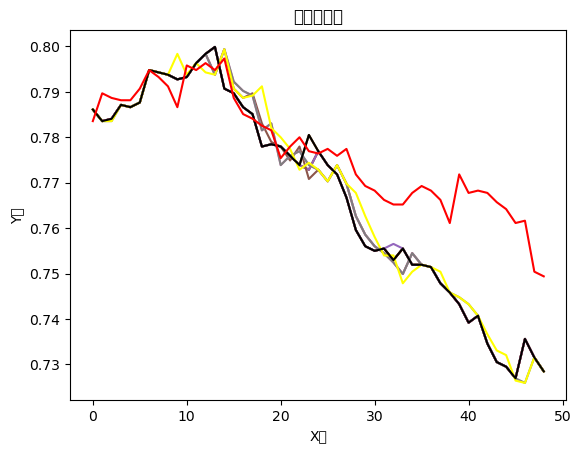

In [22]:
import matplotlib.pyplot as plt

fea_num=[i for i in range(49)]

# 创建图形
plt.plot(fea_num, aver_mean_lis1)
plt.plot(fea_num, aver_mean_lis2)
plt.plot(fea_num, aver_mean_lis3)
plt.plot(fea_num, aver_mean_lis4)
plt.plot(fea_num, aver_mean_lis5)
plt.plot(fea_num, aver_mean_lis6)
plt.plot(fea_num, aver_mean_lis7)
plt.plot(fea_num, aver_mean_lis8)
plt.plot(fea_num, aver_mean_lis9,color="yellow")
plt.plot(fea_num, rfe_SVM_aver_mean_lis,color="black")
plt.plot(fea_num, relief_SVM_aver_mean_lis,color="red")



# 添加标题和标签
plt.title('简单折线图')
plt.xlabel('X轴')
plt.ylabel('Y轴')

# 显示图形
plt.show()


In [50]:
tongren_accuracy=[]
tongren_accuracy.append(aver_mean_lis1)
tongren_accuracy.append(aver_mean_lis2)
tongren_accuracy.append(aver_mean_lis3)
tongren_accuracy.append(aver_mean_lis4)
tongren_accuracy.append(aver_mean_lis5)
tongren_accuracy.append(aver_mean_lis6)
tongren_accuracy.append(aver_mean_lis7)
tongren_accuracy.append(aver_mean_lis8)
tongren_accuracy.append(aver_mean_lis9)
tongren_accuracy.append(rfe_SVM_aver_mean_lis)
tongren_accuracy.append(relief_SVM_aver_mean_lis)

In [51]:
colu=[i for i in range(1,50)]
tongren_acurracy_dataframe=pd.DataFrame(columns=colu,data=np.array(tongren_accuracy))
tongren_acurracy_dataframe.to_csv("tongren_accuracy.csv")

In [52]:



tongren_F_measure=[]
tongren_F_measure.append(F_measure_lis1)
tongren_F_measure.append(F_measure_lis2)
tongren_F_measure.append(F_measure_lis3)
tongren_F_measure.append(F_measure_lis4)
tongren_F_measure.append(F_measure_lis5)
tongren_F_measure.append(F_measure_lis6)
tongren_F_measure.append(F_measure_lis7)
tongren_F_measure.append(F_measure_lis8)
tongren_F_measure.append(F_measure_lis9)
tongren_F_measure.append(rfe_SVM_F_measure_lis)
tongren_F_measure.append(relief_SVM_F_measure_lis)

In [53]:
colu=[i for i in range(1,50)]
tongren_F_measure_dataframe=pd.DataFrame(columns=colu,data=np.array(tongren_F_measure))
tongren_F_measure_dataframe.to_csv("tongren_F_measure.csv")